In [ ]:
import matplotlib.pylab as plt
import matplotlib as mpl
from skimage import io
from skimage import data
import numpy as np
import math
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5) # width and height
mpl.rc('image', cmap='gray')

In [ ]:
def rgb2gray(img):
    if len(img.shape) < 3:
        return img
    return 0.2125*img[:,:,0] + 0.7154*img[:,:,1] + 0.0721*img[:,:,2]

In [ ]:
def toBlocksOld(img, size_h=8, size_w=8):
    h, w = img.shape
    h, w = math.floor(h/size_h), math.floor(w/size_w)
    blocks = np.empty((h, w, size_h, size_w))
    for J in range(h):
        for I in range(w):
            new_block = np.zeros((size_h, size_w))
            y_start, x_start = J*size_h, I*size_w
            for j in range(size_h):
                for i in range(size_w):
                    new_block[j][i] = img[y_start+j][x_start+i]
            blocks[J][I] = new_block
    return blocks

In [ ]:
def toBlocks(A, n_rows=8, n_cols=8):
    if A.shape[0] % n_rows != 0 or A.shape[1] % n_cols != 0:
        rows_end = A.shape[0] - A.shape[0] % n_rows
        cols_end = A.shape[1] - A.shape[1] % n_cols
        A = A[0:rows_end, 0:cols_end]
    B = A.reshape((-1, n_rows, A.shape[1]//n_cols, n_cols))
    return B.transpose((0,2,1,3))

In [ ]:
def fromBlocksOld(img):
    (img_h, img_w, block_h, block_w) = img.shape
    output = np.zeros((img_h*block_h, img_w*block_w))
    for J in range(img_h):
        for I in range(img_w):
            block = img[J, I]
            for j in range(block_h):
                for i in range(block_w):
                    y = J * block_h + j
                    x = I * block_w + i
                    output[y, x] = block[j, i]
    return output

In [ ]:
def fromBlocks(img):
    rows = []
    for J in range(img.shape[0]):
        rows.append( np.concatenate(img[J], axis=1) )
    
    return np.array(np.concatenate(rows))

In [ ]:
def getCharacterString():
    CHARACTERS = ""
    for x in range(32,127): CHARACTERS += chr(x)
    return CHARACTERS

In [ ]:
def getCharBlocks(sentence, fontName, fontSize, block_h, block_w, inverted=False):
    myFont = ImageFont.truetype(fontName, fontSize)
    fillValue = 0
    characters = Image.open('ascii_char_holder.png')
    if inverted:
        fillValue = 255
        characters = Image.open('ascii_char_holder_black.png')
    drawer = ImageDraw.Draw(characters)
    for i, char in enumerate(sentence):
        drawer.text((i*block_w, 0), char, font=myFont, fill=0)
    #characters.show()
    characterArray = np.asarray(characters)
    characterArray = rgb2gray(characterArray)
    charBlocks = toBlocks(characterArray, block_h, block_w)
    return charBlocks[0]

In [ ]:
def getAsciiImage(image, charsToUse, textInfo):
    print("in getAsciiImage() ...\nimage size: {}x{}".format(image.shape[1],image.shape[0]))

    sentence = ""
    charBlocks = getCharBlocks(charsToUse, textInfo["fontName"], textInfo["fontSize"], textInfo["block_h"], textInfo["block_w"])
    bH, bW = textInfo["block_h"], textInfo["block_w"]

    print("converting to blocks ...")
    image_blocks = toBlocks(image, bH, bW)
    ascii_blocks = np.empty(image_blocks.shape)
    (imH, imW, rubb, ish) = image_blocks.shape

    print("blocks to process: {}x{} = {}".format(imH, imW, imH*imW))
    for iy, ix in np.ndindex(imH, imW):
        blocks_processed = iy * imW + ix
        if blocks_processed % 500 == 0: print("blocks processed = {}/{} ...".format(blocks_processed, imH*imW), end="\r")
        image_block = image_blocks[iy, ix]
        min = math.inf
        best_index = 0
        for i in range(len(charBlocks)):
            aveDiff = averagePixDiff(image_block, charBlocks[i])
            if aveDiff < min:
                min = aveDiff
                best_index = i
        
        ascii_blocks[iy, ix] = charBlocks[ best_index ]
        sentence += charsToUse[ best_index ]
        if ix == imW-1: sentence += "\n"
    print("blocks processed = {}/{} ...".format(blocks_processed, imH*imW))
    print("departitioning blocks and returning ...")
    return fromBlocks(ascii_blocks), sentence

In [ ]:
def getImage(image_name):
    folder = "images"
    return rgb2gray(io.imread( "{}\{}".format(folder, image_name) ))

In [ ]:
def averagePixDiff(im1, im2):
    if im1.shape != im2.shape:
        print("(in avePixDiff) Error: the shapes of two arrays doesn' match")
        return -1
    #return np.abs(im1-im2).mean()
    #return np.square(im1-im2).mean()
    return abs(im1.mean()-im2.mean())

In [ ]:
# RUNNER
# 
# Image files:
# Lenna.png, cliff_tree.jpg, wedding.jpg, senators.jpg, the great wave.jpg, rings_of_saturn.jpg, saturn.jpg, saturn_and_its_3_moons.jpg, cheguevara.jpg

fontName = "courier.ttf"
fontSize = 24
block_h = 24
block_w = 14

charsToUse = getCharacterString()
charBlocks = getCharBlocks(charsToUse, fontName, fontSize, block_h, block_w, inverted=True)
print(charBlocks.shape)

# GET IMAGE
image = getImage("cheguevara.jpg")
imageBlocks = toBlocks(image, block_h, block_w)

# Get darkest image block
min = math.inf
imageBlocksDarkest = imageBlocks[0]
for row in imageBlocks:
    for block in row:
        a = block.mean()
        if a < min:
            min = a
            imageBlocksDarkest = block
print("darkest image block: ", int(min))
threshLowerImage = min

# get darkest char block
min = math.inf
charBlocksDarkest = charBlocks[0]
for block in charBlocks:
    a = block.mean()
    if a < min:
        min = a
        charBlocksDarkest = block
print("darkest char block: ", int(min))
threshLowerChar = min
threshUpperChar = 255

# lightest image block
max = 0
imageBlocksLighest = imageBlocks[0]
for row in imageBlocks:
    for block in row:
        a = block.mean()
        if a > max:
            max = a
            imageBlocksLightest = block
print("lightest image block: ", int(max))
threshUpperImage = max

# scale dynamic range

DR_char = threshUpperChar - threshLowerChar
DR_image = threshUpperImage - threshLowerImage

imageBlocksScaled = ( imageBlocks - threshLowerImage ) * ( DR_char / DR_image ) + threshLowerChar

# Get darkest image block
min = math.inf
max = 0
imageBlocksScaledDarkest = imageBlocksScaled[0]
imageBlocksScaledLightest = imageBlocksScaled[0]
for row in imageBlocksScaled:
    for block in row:
        a = block.mean()
        if a < min:
            min = a
            imageBlocksScaledDarkest = block
        if a > max:
            max = a
            imageBlocksScaledLightest = block
print("darkest image scaled block: ", int(min))
print("lightest image scaled block: ", int(max))


# DISPLAY
images = (image, imageBlocksDarkest, charBlocksDarkest, imageBlocksLightest, imageBlocksScaledDarkest, imageBlocksScaledLightest)
fig, ax = plt.subplots(1, len(images))
for i, im in enumerate(images):
    ax[i].imshow(im, vmin=0, vmax=255), ax[i].axis('off')
fig.tight_layout()

In [ ]:
scaledImageDeblocked = fromBlocks(imageBlocksScaled)

imageBlock = imageBlocks[20,30]

minAve = math.inf
minMean = math.inf
best_i = 0
for i, block in enumerate(charBlocks):
    #aveDiff = averagePixDiff(imageBlock, block)
    aveDiff = np.abs(block-imageBlock).mean()
    meanDiff = abs(block.mean() - imageBlock.mean())
    #print(aveDiff)
    #aveDiff = meanDiff
    #print("aveDiff: {} meanDiff: {}".format(int(aveDiff), int(meanDiff)))
    if aveDiff < minAve:
        minAve = aveDiff
        minMean = meanDiff
        best_i = i
    #if meanDiff < minMean:

bestCharBlock = charBlocks[best_i]

print(best_i)
print("minAve: {} minMean: {}".format(int(minAve), minMean))
print("imageblock mean: ", int(imageBlock.mean()))
print("best char block mean: ", int(bestCharBlock.mean()))

i = 74
a = np.abs(charBlocks[i]-imageBlock).mean()
b = abs(charBlocks[i].mean() - imageBlock.mean())
print("charBlock {} has aveDiff: {} and meanDiff: {}".format(best_i, a, b))

#print(charBlocks[0])

block = charBlocks[74]
print(imageBlock.dtype)
print(block.dtype)
print(block)
print( np.abs(imageBlock - block).astype(int) )

# DISPLAY
images = (scaledImageDeblocked, imageBlock, block)
fig, ax = plt.subplots(1, len(images))
for i, im in enumerate(images):
    ax[i].imshow(im, vmin=0, vmax=255), ax[i].axis('off')
fig.tight_layout()

In [ ]:
# TESTING

sentence = "abcd"
charBlocks = getCharBlocks(sentence, "courier.ttf", 12, 12, 7, True)

char = 
drawer.text((i*block_w, 0), char, font=myFont, fill=0)

print(charBlocks[2])

# DISPLAY
images = (charBlocks[1])
fig, ax = plt.subplots(1, len(images))
for i, im in enumerate(images):
    ax[i].imshow(im, vmin=0, vmax=255), ax[i].axis('off')
fig.tight_layout()

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

(-0.5, 13.5, 23.5, -0.5)

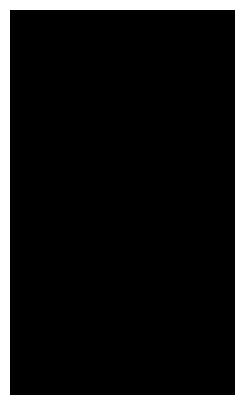

In [33]:
sentence = "abcd"
font_size = 24
block_w = int(font_size / 12 * 7)
block_h = font_size
myFont = ImageFont.truetype("courier.ttf", font_size)
fillValue = 255
characters = Image.open('ascii_char_holder_black.png')
drawer = ImageDraw.Draw(characters)
for i, char in enumerate(sentence):
    drawer.text((i*block_w, 0), char, font=myFont, fill=(0, 0, 0))
#characters.show()
characterArray = np.asarray(characters)
characterArray = rgb2gray(characterArray)
charBlocks = toBlocks(characterArray, block_h, block_w)[0]

print(charBlocks[1])

# DISPLAY

fig, ax = plt.subplots()

ax.imshow(charBlocks[1], vmin=0, vmax=255)
ax.axis('off')

#images = (charBlocks[1])
#fig, ax = plt.subplots(1, len(images))
#for i, im in enumerate(images):
#    ax[i].imshow(im, vmin=0, vmax=255), ax[i].axis('off')
#fig.tight_layout()